In [1]:
from QAOA import QAOArunner
from MaxCutProblem import MaxCutProblem
import params
from rustworkx.visualization import mpl_draw as draw_graph
from load_data import load_graph_from_csv

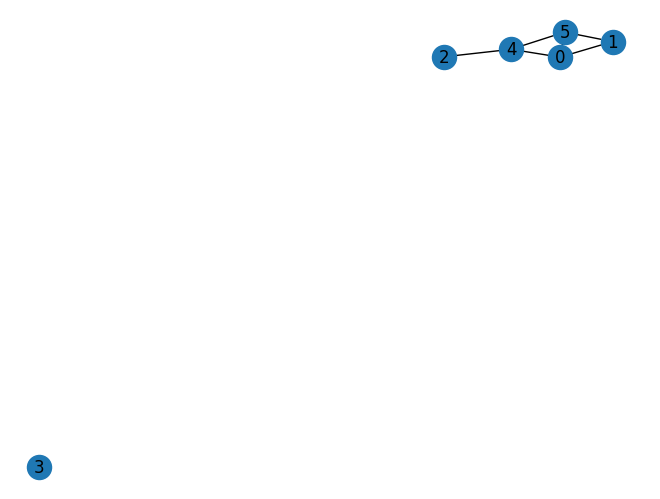

In [2]:
problem = MaxCutProblem()
graph = problem.get_graph(6, create_random=True,random_weights=False)
#graph = load_graph_from_csv('data/11_nodes_links_scand.csv')
draw_graph(graph, with_labels=True)

In [3]:
quantum = QAOArunner(graph=graph, 
                     simulation=True,
                     param_initialization= 'gaussian',
                     qaoa_variant='normal', 
                     optimizer='COBYLA',
                     warm_start=False,
                     test_hamil = True
                     )

quantum.build_circuit()
quantum.run()
quantum.draw_circuit()
#TODO: account for random weigts?

Should be:  SparsePauliOp(['IZIZII', 'IIIIZZ', 'IZIIIZ', 'ZIIIZI', 'ZZIIII', 'ZIIIIZ'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])
Is:  SparsePauliOp(['IIIIZZ', 'IZIIIZ', 'ZIIIIZ', 'ZIIIZI', 'IZIZII', 'ZZIIII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])
Num qubits:  6


AttributeError: 'QuantumCircuit' object has no attribute 'cost_operator'

In [ ]:
from solver import Solver


solver = Solver(graph)
quantum.compare_solutions(solver.solve())

Result quantum [1, 1, 1, 0, 0, 1] Objective value:  5
Result input (classical) [1.0, 1.0, 0, 0, 0, 1.0] Objective Value:  5.0
Same solution False
Same objective function value:  True


In [ ]:
quantum.get_prob_distribution()

{28: 610, 39: 1210, 56: 15, 37: 579, 42: 394, 44: 320, 22: 160, 26: 572, 24: 1193, 19: 316, 62: 21, 21: 344, 31: 109, 35: 634, 41: 142, 23: 331, 25: 109, 10: 64, 55: 282, 53: 74, 29: 118, 51: 65, 14: 21, 47: 136, 52: 15, 40: 352, 32: 102, 36: 124, 17: 67, 8: 271, 43: 33, 38: 116, 45: 32, 16: 164, 12: 57, 49: 26, 54: 67, 0: 25, 48: 15, 63: 29, 6: 15, 11: 22, 57: 27, 9: 66, 2: 11, 27: 118, 34: 111, 46: 84, 18: 41, 15: 19, 58: 2, 4: 9, 20: 41, 33: 5, 1: 24, 13: 16, 50: 17, 30: 10, 61: 13, 59: 16, 5: 4, 7: 10, 3: 2, 60: 3}
{28: 0.061, 39: 0.121, 56: 0.0015, 37: 0.0579, 42: 0.0394, 44: 0.032, 22: 0.016, 26: 0.0572, 24: 0.1193, 19: 0.0316, 62: 0.0021, 21: 0.0344, 31: 0.0109, 35: 0.0634, 41: 0.0142, 23: 0.0331, 25: 0.0109, 10: 0.0064, 55: 0.0282, 53: 0.0074, 29: 0.0118, 51: 0.0065, 14: 0.0021, 47: 0.0136, 52: 0.0015, 40: 0.0352, 32: 0.0102, 36: 0.0124, 17: 0.0067, 8: 0.0271, 43: 0.0033, 38: 0.0116, 45: 0.0032, 16: 0.0164, 12: 0.0057, 49: 0.0026, 54: 0.0067, 0: 0.0025, 48: 0.0015, 63: 0.0029, 

c:\Users\torbjsme\Master\QAOA\myenv\lib\site-packages\qiskit\providers\fake_provider\generic_backend_v2.py:963: RuntimeWarning: Aer not found using BasicSimulator and no noise
  warnings.warn("Aer not found using BasicSimulator and no noise", RuntimeWarning)


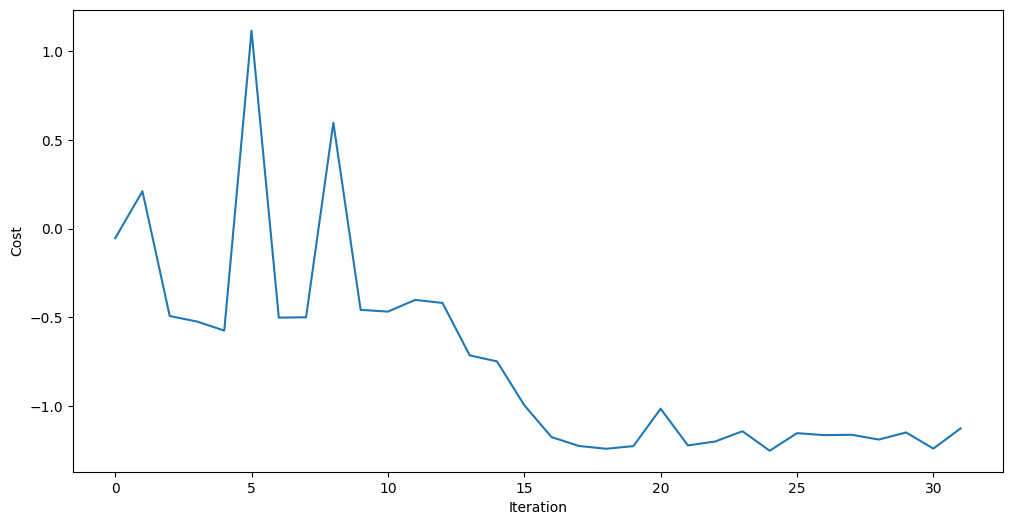

In [ ]:
quantum.draw_objective_value()

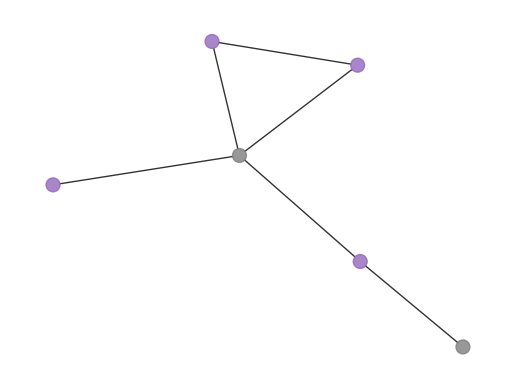

In [ ]:
quantum.plot_result()

In [ ]:
import csv

import numpy as np
import rustworkx as rx
from rustworkx import is_connected
from rustworkx.visualization import mpl_draw as draw_graph
import pandas as pd
import geopandas as gpd
import cartopy.feature as cfeature

import cartopy.crs as ccrs
import matplotlib.pyplot as plt

def load_edges_verbose(file_path):
    df = pd.read_csv(file_path,delimiter=';',index_col=0)
    result = [(row, col, 1) for (row, col), value in df.stack().items() if value == 1]
    return result


def draw_nodes_on_cartopy(file_path, bitstring=None):
    
    df = pd.read_csv(file_path, delimiter=';')
    edges = load_edges_verbose('data/11_nodes_links_scand.csv')
    
    # Rename the first column
    df.rename(columns={df.columns[0]: 'name'}, inplace=True)
    # Set up a GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['y'], df['x']))

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

    # Add map features
    ax.set_extent([4, 25, 54, 72], crs=ccrs.PlateCarree())  # Set the extent to cover Norway, Denmark, Sweden
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
    ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')
    ax.add_feature(cfeature.COASTLINE, edgecolor='black')
    ax.add_feature(cfeature.LAKES, facecolor='lightblue', edgecolor='black')
    ax.add_feature(cfeature.RIVERS, edgecolor='blue')
    gl = ax.gridlines(draw_labels=True, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
  
    # Plot nodes on the map
    
    
    for start_label, end_label, weight in edges:
        start_coords = (df[df['name']==start_label]['y'], df[df['name']==start_label]['x'])
        end_coords = (df[df['name']==end_label]['y'], df[df['name']==end_label]['x'])
        ax.plot(
            [start_coords[0], end_coords[0]],  # x-coordinates (longitudes)
            [start_coords[1], end_coords[1]],  # y-coordinates (latitudes)
            color='black', linewidth=1 + weight, transform=ccrs.PlateCarree(), zorder=1
        )
    if bitstring is not None:
        colors = ['red' if bit == 1 else 'blue' for bit in bitstring]
    else:
        colors = 'red'
    
    gdf.plot(ax=ax, color=colors, markersize=50, transform=ccrs.PlateCarree(), edgecolor='black', label='Node')

    for idx, row in gdf.iterrows():
        ax.text(row.geometry.x + 0.005, row.geometry.y, row['name'], transform=ccrs.PlateCarree(),
                ha='left', fontsize=10, color='darkred', fontweight='bold')

    
    plt.legend()
    plt.title("Nodes on Norway, Denmark, and Sweden")
    plt.show()
#draw_nodes_on_cartopy('data/11_nodes_coords_scand.csv', bitstring=quantum.solution)



